# Spike Predicción de precio de Leche 

## Importando las librerias a utilizar

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime
import numpy as np
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
#%matplotlib inline
pd.options.mode.chained_assignment = None
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model

## Carga de Datos

1. Datos: Precipitaciones, Indicadores Económicos Banco Central

*   Cargar archivo precipitaciones.csv con las precipitaciones medias mensuales
registradas entre enero 1979 y abril 2020. (Unidad: mm).
*   Cargar archivo banco_central.csv con variables económicas.



In [2]:
milk_price = pd.read_csv('./data/precio_leche.csv')

In [3]:
precipitation = pd.read_csv('./data/precipitaciones.csv')

In [4]:
central_bank = pd.read_csv('./data/banco_central.csv')

2. Análisis de datos. Creación de variables

*   Realiza un análisis exploratorio de la base de datos, ¿Qué puedes decir de los datos,
sus distribuciones, valores faltantes, otros? ¿Hay algo que te llame la atención?
*   Realiza una limpieza de datos para que las series de tiempo no tengan duplicados ni
valores incorrectos.



## Análisis Exploratorio de datos


### Análisis y manejo del dataset de Leche

In [5]:
print( 'Shape de la data de leche: {}'.format(milk_price.shape))

Shape de la data de leche: (506, 3)


In [6]:
print( 'Descripción de la data de leche: \n\n {}'.format(milk_price.describe()))

Descripción de la data de leche: 

               Anio  Precio_leche
count   506.000000    506.000000
mean   1999.584980    114.444980
std      12.183973     78.999882
min    1979.000000      3.850000
25%    1989.000000     48.162500
50%    2000.000000    102.250000
75%    2010.000000    189.175000
max    2021.000000    318.880000


In [7]:
print( 'Info de la data de leche: \n\n {}'.format(milk_price.info()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Anio          506 non-null    int64  
 1   Mes           506 non-null    object 
 2   Precio_leche  506 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 12.0+ KB
Info de la data de leche: 

 None


In [8]:
milk_price.head()

,Anio,Mes,Precio_leche
0,1979,Ene,3.85
1,1979,Feb,4.58
2,1979,Mar,5.18
3,1979,Abr,6.06
4,1979,May,7.25


Se convierten las columnas Anio y Mes en una sola columna denominada Fecha para estandarizar

In [9]:
#Convertir meses a meses numéricos
list_months = [x for x in milk_price.Mes[:12]]
print('El listado de meses original es {}'.format(list_months))

month_dic = {}
for index, month in enumerate(list_months):
  if (index <9):
     month_dic[month] = '0{}'.format(index+1)
  else:
    month_dic[month] = '{}'.format(index+1)


milk_price["Mes"] = milk_price["Mes"].map(month_dic)

milk_price.head()

El listado de meses original es ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']


,Anio,Mes,Precio_leche
0,1979,01,3.85
1,1979,02,4.58
2,1979,03,5.18
3,1979,04,6.06
4,1979,05,7.25


In [10]:
#Convertir columnas de Anio y Mes a string
milk_price["Anio"] = milk_price["Anio"].astype(str)
milk_price["Mes"] = milk_price["Mes"].astype(str)

In [11]:
#Crear Columna de Fecha en String
milk_price["Fecha"] = milk_price.Anio + "-" + milk_price.Mes

In [12]:
milk_data =milk_price.drop(["Anio", "Mes"], axis=1)
milk_data = milk_data[["Fecha", "Precio_leche"]]
milk_data.head()

,Fecha,Precio_leche
0,1979-01,3.85
1,1979-02,4.58
2,1979-03,5.18
3,1979-04,6.06
4,1979-05,7.25


In [13]:
milk_data.tail()

,Fecha,Precio_leche
501,2020-10,274.32
502,2020-11,288.09
503,2020-12,287.29
504,2021-01,287.60
505,2021-02,295.24


In [14]:
milk_data.isnull().sum()

Fecha           0
Precio_leche    0
dtype: int64

### Análisis y manejo del dataset de banco

In [15]:
print( 'Shape de la data de banco: {}'.format(central_bank.shape))

Shape de la data de banco: (614, 85)


In [16]:
print( 'Descripción de la data de banco: \n\n {}'.format(central_bank.describe()))

Descripción de la data de banco: 

        Precio_de_la_onza_troy_de_oro_dolaresoz  \
count                               613.000000   
mean                                578.706574   
std                                 468.018646   
min                                  34.940000   
25%                                 292.540000   
50%                                 385.040000   
75%                                 828.800000   
max                                1969.780000   

       Precio_de_la_onza_troy_de_plata_dolaresoz  \
count                                 613.000000   
mean                                   54.202123   
std                                    89.493857   
min                                     1.320000   
25%                                     4.760000   
50%                                     6.080000   
75%                                    35.080000   
max                                   431.028000   

       Precio_del_diesel_centavos_de_dolarga

In [17]:
print( 'Info de la data de banco: \n\n {}'.format(central_bank.info()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 85 columns):
 #   Column                                                                              Non-Null Count  Dtype  
---  ------                                                                              --------------  -----  
 0   Periodo                                                                             614 non-null    object 
 1   Imacec_empalmado                                                                    300 non-null    object 
 2   Imacec_produccion_de_bienes                                                         300 non-null    object 
 3   Imacec_minero                                                                       300 non-null    object 
 4   Imacec_industria                                                                    301 non-null    object 
 5   Imacec_resto_de_bienes                                                              300 non-null   

In [18]:
central_bank.head()

,Periodo,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,Imacec_resto_de_bienes,Imacec_comercio,Imacec_servicios,Imacec_a_costo_de_factores,Imacec_no_minero,...,Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100,Indice_de_produccion_industrial,Indice_de_produccion_industrial__mineria,Indice_de_produccion_industrial_electricidad__gas_y_agua,Indice_de_produccion_industrial__manufacturera,Generacion_de_energia_electrica_CDEC_GWh,Indice_de_ventas_comercio_real_IVCM,Indice_de_ventas_comercio_real_no_durables_IVCM,Indice_de_ventas_comercio_real_durables_IVCM,Ventas_autos_nuevos
0,2013-03-01 00:00:00 UTC,102.796.218,10.546.824,978.554.365,102.297.537,114.994.919,110.729.395,100.064.328,103.163.651,103.405.852,...,865.903.468,102.761.705,98.915.705,NaN,108.387.837,580.480.672,NaN,NaN,NaN,28577.0
1,2013-04-01 00:00:00 UTC,101.664.842,999.272.757,927.333.293,104.485.589,102.199.311,106.098.291,102.600.107,101.937.319,102.766.884,...,867.806.065,968.087.179,914.276.663,NaN,104.545.429,544.815.032,NaN,NaN,NaN,32206.0
2,2013-05-01 00:00:00 UTC,101.642.954,993.959.922,96.133.164,105.445.361,968.789.055,100.462.117,104.083.216,101.953.299,102.322.796,...,878.030.947,978.471.874,966.913.278,NaN,99.468.801,56.891.916,NaN,NaN,NaN,31589.0
3,2013-06-01 00:00:00 UTC,998.310.201,968.367.884,102.400.933,999.212.106,89.190.493,939.504.414,103.857.161,100.222.381,995.139.235,...,913.180.348,966.647.135,981.820.974,NaN,94.969.678,56.594.867,NaN,NaN,NaN,28457.0
4,2013-07-01 00:00:00 UTC,964.696.194,961.051.418,980.029.022,100.882.112,901.785.886,92.776.599,969.309.272,962.069.134,962.804.305,...,909.263.447,100.100.749,990.198.382,NaN,102.128.977,586.329.899,NaN,NaN,NaN,31736.0


Se encuentra que los datos de banco cuentan con una gran cantidad de celdas vacias, por lo que en celdas posteriores se tratara con estas columnas problematicas

In [19]:
central_bank.isnull().sum()

Periodo                                              0
Imacec_empalmado                                   314
Imacec_produccion_de_bienes                        314
Imacec_minero                                      314
Imacec_industria                                   313
                                                  ... 
Generacion_de_energia_electrica_CDEC_GWh           350
Indice_de_ventas_comercio_real_IVCM                530
Indice_de_ventas_comercio_real_no_durables_IVCM    530
Indice_de_ventas_comercio_real_durables_IVCM       529
Ventas_autos_nuevos                                469
Length: 85, dtype: int64

In [20]:
# Se inicia el proceso de acomodar las fechas para que queden con la misma estructura que la columna fecha del dataset de leche (milk_data)
central_bank["Periodo"].unique()

array(['2013-03-01 00:00:00 UTC', '2013-04-01 00:00:00 UTC',
       '2013-05-01 00:00:00 UTC', '2013-06-01 00:00:00 UTC',
       '2013-07-01 00:00:00 UTC', '2013-08-01 00:00:00 UTC',
       '2013-09-01 00:00:00 UTC', '2013-10-01 00:00:00 UTC',
       '2013-11-01 00:00:00 UTC', '2013-12-01 00:00:00 UTC',
       '2014-01-01 00:00:00 UTC', '2014-02-01 00:00:00 UTC',
       '2014-03-01 00:00:00 UTC', '2014-04-01 00:00:00 UTC',
       '2014-05-01 00:00:00 UTC', '2014-06-01 00:00:00 UTC',
       '2014-07-01 00:00:00 UTC', '2014-08-01 00:00:00 UTC',
       '2014-09-01 00:00:00 UTC', '2014-10-01 00:00:00 UTC',
       '2014-11-01 00:00:00 UTC', '2014-12-01 00:00:00 UTC',
       '2015-01-01 00:00:00 UTC', '2015-02-01 00:00:00 UTC',
       '2015-03-01 00:00:00 UTC', '2015-04-01 00:00:00 UTC',
       '2015-05-01 00:00:00 UTC', '2015-06-01 00:00:00 UTC',
       '2015-07-01 00:00:00 UTC', '2015-08-01 00:00:00 UTC',
       '2015-09-01 00:00:00 UTC', '2015-10-01 00:00:00 UTC',
       '2015-11-01 00:00

In [21]:
central_bank["Periodo"] = central_bank["Periodo"].astype(str)
f = lambda x: x.split("-")[0] + "-" +  x.split("-")[1]
central_bank["Periodo"] = central_bank["Periodo"].apply(f)
central_bank.head()

,Periodo,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,Imacec_resto_de_bienes,Imacec_comercio,Imacec_servicios,Imacec_a_costo_de_factores,Imacec_no_minero,...,Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100,Indice_de_produccion_industrial,Indice_de_produccion_industrial__mineria,Indice_de_produccion_industrial_electricidad__gas_y_agua,Indice_de_produccion_industrial__manufacturera,Generacion_de_energia_electrica_CDEC_GWh,Indice_de_ventas_comercio_real_IVCM,Indice_de_ventas_comercio_real_no_durables_IVCM,Indice_de_ventas_comercio_real_durables_IVCM,Ventas_autos_nuevos
0,2013-03,102.796.218,10.546.824,978.554.365,102.297.537,114.994.919,110.729.395,100.064.328,103.163.651,103.405.852,...,865.903.468,102.761.705,98.915.705,NaN,108.387.837,580.480.672,NaN,NaN,NaN,28577.0
1,2013-04,101.664.842,999.272.757,927.333.293,104.485.589,102.199.311,106.098.291,102.600.107,101.937.319,102.766.884,...,867.806.065,968.087.179,914.276.663,NaN,104.545.429,544.815.032,NaN,NaN,NaN,32206.0
2,2013-05,101.642.954,993.959.922,96.133.164,105.445.361,968.789.055,100.462.117,104.083.216,101.953.299,102.322.796,...,878.030.947,978.471.874,966.913.278,NaN,99.468.801,56.891.916,NaN,NaN,NaN,31589.0
3,2013-06,998.310.201,968.367.884,102.400.933,999.212.106,89.190.493,939.504.414,103.857.161,100.222.381,995.139.235,...,913.180.348,966.647.135,981.820.974,NaN,94.969.678,56.594.867,NaN,NaN,NaN,28457.0
4,2013-07,964.696.194,961.051.418,980.029.022,100.882.112,901.785.886,92.776.599,969.309.272,962.069.134,962.804.305,...,909.263.447,100.100.749,990.198.382,NaN,102.128.977,586.329.899,NaN,NaN,NaN,31736.0


In [22]:
#  Reinicio del index y organizando los datos en orden de fecha
central_bank = central_bank.sort_values(by=['Periodo']).reset_index(drop=True)
central_bank.head(10)

,Periodo,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,Imacec_resto_de_bienes,Imacec_comercio,Imacec_servicios,Imacec_a_costo_de_factores,Imacec_no_minero,...,Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100,Indice_de_produccion_industrial,Indice_de_produccion_industrial__mineria,Indice_de_produccion_industrial_electricidad__gas_y_agua,Indice_de_produccion_industrial__manufacturera,Generacion_de_energia_electrica_CDEC_GWh,Indice_de_ventas_comercio_real_IVCM,Indice_de_ventas_comercio_real_no_durables_IVCM,Indice_de_ventas_comercio_real_durables_IVCM,Ventas_autos_nuevos
0,1970-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1970-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1970-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1970-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1970-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1970-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1970-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1970-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1970-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1970-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
#Información de columnas con 30% o mas de datos faltantes

counter = 0
percentage = 30
for column in central_bank.columns:

  if (central_bank[column].isnull().sum() > percentage*0.01*len(central_bank)):
  #if (central_bank[column].isnull().sum() > 500):
    counter += 1
    #print('Missing Values in {} is: {}'.format(column, central_bank[column].isnull().sum()))

print('\n Columnas con mas del {}% de datos faltantes: {}'.format(percentage, counter))
print('\n Shape del dataset de banco: {}'.format(central_bank.shape))


 Columnas con mas del 30% de datos faltantes: 78

 Shape del dataset de banco: (614, 85)


Se observa que 78 de las 85 columnas del dataset cuentan con más del 30% de datos faltantes, como primera aproximación se eliminaran estas columnas para realizar un modelo 

In [24]:
counter = 0
percentage = 30
drop_columns = []
for column in central_bank.columns:

  if (central_bank[column].isnull().sum() > percentage*0.01*len(central_bank)):
    drop_columns.append(column)


central_bank.drop(drop_columns, axis=1, inplace=True)

central_bank.shape

(614, 7)

Después de la limpieza de aquellas columnas que tenian más del 30% de datos faltantes, se reduce a 7 columnas el dataset

In [25]:
central_bank.isnull().sum()

Periodo                                         0
Precio_de_la_gasolina_en_EEUU_dolaresm3        20
Precio_de_la_onza_troy_de_oro_dolaresoz         1
Precio_de_la_onza_troy_de_plata_dolaresoz       1
Precio_del_cobre_refinado_BML_dolareslibra      1
Precio_del_petroleo_WTI_dolaresbarril         161
Tipo_de_cambio_del_dolar_observado_diario     152
dtype: int64

In [26]:
# Se busca desde que punto inicia la fecha asociada al dataset milk_price
central_bank[central_bank["Periodo"] == "1979-01"]

,Periodo,Precio_de_la_gasolina_en_EEUU_dolaresm3,Precio_de_la_onza_troy_de_oro_dolaresoz,Precio_de_la_onza_troy_de_plata_dolaresoz,Precio_del_cobre_refinado_BML_dolareslibra,Precio_del_petroleo_WTI_dolaresbarril,Tipo_de_cambio_del_dolar_observado_diario
108,1979-01,136.72,227.27,6.26,752,NaN,NaN


In [27]:
 New_central_bank = central_bank[108:]

In [28]:
New_central_bank.head()

,Periodo,Precio_de_la_gasolina_en_EEUU_dolaresm3,Precio_de_la_onza_troy_de_oro_dolaresoz,Precio_de_la_onza_troy_de_plata_dolaresoz,Precio_del_cobre_refinado_BML_dolareslibra,Precio_del_petroleo_WTI_dolaresbarril,Tipo_de_cambio_del_dolar_observado_diario
108,1979-01,136.72,227.27,6.26,752,NaN,NaN
109,1979-02,167.13,245.67,7.42,882,NaN,NaN
110,1979-03,166.71,242.05,7.45,0.93,NaN,NaN
111,1979-04,198.31,239.16,7.49,952,NaN,NaN
112,1979-05,249.33,257.61,8.37,873,NaN,NaN


In [29]:
New_central_bank.tail()

,Periodo,Precio_de_la_gasolina_en_EEUU_dolaresm3,Precio_de_la_onza_troy_de_oro_dolaresoz,Precio_de_la_onza_troy_de_plata_dolaresoz,Precio_del_cobre_refinado_BML_dolareslibra,Precio_del_petroleo_WTI_dolaresbarril,Tipo_de_cambio_del_dolar_observado_diario
609,2020-08,3.180.968,1969.78,270.033,294.688.379,42.36,784.661.905
610,2020-09,30.850.634,1923.35,257.916,30.447.292,39.60,773.402.381
611,2020-10,30.028.972,1900.36,241.857,304.035.653,39.53,788.267.143
612,2020-11,29.756.846,1866.35,240.693,320.395.083,41.10,762.884.762
613,2020-13,NaN,NaN,NaN,NaN,NaN,NaN


Se encuentra que hay columnas que tienen valores atipicos no numéricos, por ejemplo el valor de la fila 612 en la celda superior para la columna **"Precio_de_la_gasolina_en_EEUU_dolaresm3"** que es de 29.756.846. Se procede a encontrar de las columnas restantes cuales tienen este tipo de datos atípicos

In [30]:
for column in New_central_bank.columns[1:]:
  print('Para la columna {} los valores unicos son \n {}'.format(column,New_central_bank[column].unique())) 
  print('------------------------------------------------------------------------------------------------')

Para la columna Precio_de_la_gasolina_en_EEUU_dolaresm3 los valores unicos son 
 ['136.72' '167.13' '166.71' '198.31' '249.33' '298.2' '228.56' '206.76'
 '232.34' '256.43' '298.36' '299.26' '267.19' '257.15' '245.79' '260.92'
 '263.72' '244.33' '230.07' '228.77' '235.46' '242.46' '249.09' '248.61'
 '258.04' '271.52' '270.54' '265.52' '266.08' '266.21' '274.77' '272.84'
 '265.2' '265.84' '266.1' '252.44' '245.26' '239.1' '220.5' '236.38'
 '257.81' '260.18' '252.02' '255.59' '254' '236.49' '223.96' '222.83'
 '218.49' '212.39' '229.77' '230.01' '231.84' '229.48' '228.64' '224.99'
 '216.12' '211.12' '196.22' '207.08' '213.21' '217.57' '216.54' '210.81'
 '200.95' '197.2' '203.57' '206.63' '199.15' '185.57' '176.43' '181'
 '196.3' '210.09' '217.09' '215.19' '216.01' '210.65' '198.86' '200.4'
 '208.53' '210.3' '183.2' '164.28' '118.78' '105.36' '120.92' '134.29'
 '107.93' '87.79' '109.67' '105.63' '108.56' '109.46' '130.14' '127.45'
 '134.27' '133.79' '139.02' '141.58' '145.55' '141.19' '131.

In [31]:
columnas_atipicas = [ "Precio_de_la_gasolina_en_EEUU_dolaresm3", 
                  "Precio_del_cobre_refinado_BML_dolareslibra", 
                  "Tipo_de_cambio_del_dolar_observado_diario" ,
                    ]

In [32]:
Final_central_bank = New_central_bank.drop(columnas_atipicas, axis=1)
Final_central_bank

,Periodo,Precio_de_la_onza_troy_de_oro_dolaresoz,Precio_de_la_onza_troy_de_plata_dolaresoz,Precio_del_petroleo_WTI_dolaresbarril
108,1979-01,227.27,6.260,NaN
109,1979-02,245.67,7.420,NaN
110,1979-03,242.05,7.450,NaN
111,1979-04,239.16,7.490,NaN
112,1979-05,257.61,8.370,NaN
...,...,...,...,...
609,2020-08,1969.78,270.033,42.36
610,2020-09,1923.35,257.916,39.60
611,2020-10,1900.36,241.857,39.53
612,2020-11,1866.35,240.693,41.10


In [33]:
Final_central_bank.isnull().sum()

Periodo                                       0
Precio_de_la_onza_troy_de_oro_dolaresoz       1
Precio_de_la_onza_troy_de_plata_dolaresoz     1
Precio_del_petroleo_WTI_dolaresbarril        53
dtype: int64

In [34]:
Final_central_bank = Final_central_bank.sort_values(by=['Periodo']).reset_index(drop=True)

Se observa que en la columna 613 existe el mes 13, lo que no tiene sentido y explica que la columna sea de datos NaN

In [35]:
Final_central_bank[Final_central_bank.Periodo.astype(str).str[-2:] == "13"] 

,Periodo,Precio_de_la_onza_troy_de_oro_dolaresoz,Precio_de_la_onza_troy_de_plata_dolaresoz,Precio_del_petroleo_WTI_dolaresbarril
505,2020-13,NaN,NaN,NaN


In [36]:
Final_central_bank = Final_central_bank[:505]

In [37]:
Final_central_bank.tail()

,Periodo,Precio_de_la_onza_troy_de_oro_dolaresoz,Precio_de_la_onza_troy_de_plata_dolaresoz,Precio_del_petroleo_WTI_dolaresbarril
500,2020-07,1846.37,205.899,40.75
501,2020-08,1969.78,270.033,42.36
502,2020-09,1923.35,257.916,39.60
503,2020-10,1900.36,241.857,39.53
504,2020-11,1866.35,240.693,41.10


In [38]:
Final_central_bank.isnull().sum()

Periodo                                       0
Precio_de_la_onza_troy_de_oro_dolaresoz       0
Precio_de_la_onza_troy_de_plata_dolaresoz     0
Precio_del_petroleo_WTI_dolaresbarril        52
dtype: int64

In [39]:
#Se buscan los datos Null de la columna  Precio_del_petroleo_WTI_dolaresbarril        
Final_central_bank[Final_central_bank.Precio_del_petroleo_WTI_dolaresbarril.isnull()]

,Periodo,Precio_de_la_onza_troy_de_oro_dolaresoz,Precio_de_la_onza_troy_de_plata_dolaresoz,Precio_del_petroleo_WTI_dolaresbarril
0,1979-01,227.27,6.26,NaN
1,1979-02,245.67,7.42,NaN
2,1979-03,242.05,7.45,NaN
3,1979-04,239.16,7.49,NaN
4,1979-05,257.61,8.37,NaN
5,1979-06,279.07,8.54,NaN
6,1979-07,294.69,9.14,NaN
7,1979-08,300.81,9.33,NaN
8,1979-09,355.11,13.96,NaN
9,1979-10,391.66,16.78,NaN


Se observa que todos estos datos nulos van desde 1979-1 hasta 1987-07, se eliminaran estas filas, teniendo en cuenta que se reduciran 52 datos del dataset final, puede que esta decision se retire posteriormente para una segunda versión del modelo

In [40]:
Final_central_bank = Final_central_bank[52:]

In [41]:
Final_central_bank.isnull().sum()

Periodo                                      0
Precio_de_la_onza_troy_de_oro_dolaresoz      0
Precio_de_la_onza_troy_de_plata_dolaresoz    0
Precio_del_petroleo_WTI_dolaresbarril        0
dtype: int64

In [42]:
#Se cambia el nombre de Periodo a Fecha
Final_central_bank  = Final_central_bank.rename( columns={"Periodo": "Fecha"})

In [43]:
Final_central_bank = Final_central_bank.sort_values(by=['Fecha']).reset_index(drop=True)

In [44]:
Final_central_bank.head()

,Fecha,Precio_de_la_onza_troy_de_oro_dolaresoz,Precio_de_la_onza_troy_de_plata_dolaresoz,Precio_del_petroleo_WTI_dolaresbarril
0,1983-05,438.01,12.98,30.1
1,1983-06,412.84,11.75,31.0
2,1983-07,422.72,12.09,31.6
3,1983-08,416.68,12.10,31.9
4,1983-09,411.80,11.91,31.2


In [45]:
Final_central_bank.shape

(453, 4)

### Análisis y manejo del dataset de precipitaciones

In [46]:
print( 'Shape de la data de precipitacion: {}'.format(precipitation.shape))

Shape de la data de precipitacion: (496, 9)


In [47]:
print( 'Descripción de la data de precipitacion: \n\n {}'.format(precipitation.describe()))

Descripción de la data de precipitacion: 

          Coquimbo  Valparaiso  Metropolitana_de_Santiago  \
count  496.000000  496.000000                 496.000000   
mean    16.154691   32.450980                  49.666682   
std     32.629286   55.434330                  74.361099   
min      0.000000    0.000000                   0.000000   
25%      0.821521    1.538162                   5.297546   
50%      4.071036    9.037825                  19.087592   
75%     16.137600   38.409213                  63.408364   
max    347.133889  441.048604                 524.592667   

       Libertador_Gral__Bernardo_O_Higgins       Maule      Biobio  \
count                           496.000000  496.000000  496.000000   
mean                             72.249805   98.662773  128.113406   
std                             101.426112  122.766771  130.056094   
min                               0.000000    0.000000    0.001170   
25%                               5.343992   11.897363   29.35668

In [48]:
print( 'Info de la data de precipitacion: \n\n {}'.format(precipitation.info()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   date                                 496 non-null    object 
 1   Coquimbo                             496 non-null    float64
 2   Valparaiso                           496 non-null    float64
 3   Metropolitana_de_Santiago            496 non-null    float64
 4   Libertador_Gral__Bernardo_O_Higgins  496 non-null    float64
 5   Maule                                496 non-null    float64
 6   Biobio                               496 non-null    float64
 7   La_Araucania                         496 non-null    float64
 8   Los_Rios                             496 non-null    float64
dtypes: float64(8), object(1)
memory usage: 35.0+ KB
Info de la data de precipitacion: 

 None


In [49]:
precipitation.head()

,date,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios
0,1989-02-01,0.719033,0.117045,0.028272,0.0,0.724667,9.172945,22.595834,52.268010
1,1998-10-01,0.065216,0.000000,0.011493,0.0,0.008968,2.089674,14.702087,45.142041
2,2001-02-01,2.030026,0.047987,0.002634,0.0,0.032163,10.768351,29.465057,65.571098
3,2008-11-01,0.622784,0.000000,0.015872,0.0,1.734168,25.083557,64.901645,113.093488
4,2009-04-01,0.008065,0.000000,0.009396,0.0,12.080715,56.233424,96.364235,155.622235


In [50]:
precipitation.date.unique()

array(['1989-02-01', '1998-10-01', '2001-02-01', '2008-11-01',
       '2009-04-01', '2015-01-01', '2016-03-01', '2020-03-01',
       '1988-12-01', '2015-12-01', '2009-09-01', '2003-01-01',
       '1989-03-01', '2000-11-01', '2008-03-01', '2000-01-01',
       '2006-08-01', '1989-07-01', '1984-12-01', '2001-04-01',
       '1997-04-01', '1997-03-01', '1982-12-01', '1998-12-01',
       '2007-10-01', '1996-06-01', '2015-03-01', '1992-08-01',
       '1998-01-01', '2006-03-01', '1985-03-01', '2011-09-01',
       '1983-01-01', '2010-03-01', '1979-10-01', '2005-08-01',
       '1999-04-01', '1986-11-01', '2020-01-01', '2008-01-01',
       '2003-04-01', '2016-01-01', '2008-12-01', '2002-06-01',
       '2003-12-01', '1994-03-01', '2011-12-01', '2001-11-01',
       '2016-11-01', '1984-10-01', '2013-05-01', '2018-11-01',
       '2002-04-01', '1999-01-01', '2019-05-01', '1990-04-01',
       '2012-03-01', '1982-06-01', '2003-08-01', '1995-07-01',
       '1999-06-01', '1989-08-01', '1990-06-01', '2018-

In [51]:
#Convirtiendo los datos de date para que sean iguales a los datos de Fecha del dataset milk_price
precipitation["date"] = precipitation["date"].astype(str)
f = lambda x: x.split("-")[0] + "-" +  x.split("-")[1]
precipitation["date"] = precipitation["date"].apply(f)
precipitation.head()

,date,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios
0,1989-02,0.719033,0.117045,0.028272,0.0,0.724667,9.172945,22.595834,52.268010
1,1998-10,0.065216,0.000000,0.011493,0.0,0.008968,2.089674,14.702087,45.142041
2,2001-02,2.030026,0.047987,0.002634,0.0,0.032163,10.768351,29.465057,65.571098
3,2008-11,0.622784,0.000000,0.015872,0.0,1.734168,25.083557,64.901645,113.093488
4,2009-04,0.008065,0.000000,0.009396,0.0,12.080715,56.233424,96.364235,155.622235


In [52]:
precipitation = precipitation.sort_values(by=['date']).reset_index(drop=True)
precipitation.head(10)

,date,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios
0,1979-01,2.641948,0.587062,2.447114,1.608992,3.736215,17.859634,25.212940,45.596447
1,1979-02,1.179804,2.432192,3.997852,4.346310,16.347637,17.680612,18.085072,34.075039
2,1979-03,0.255490,0.020601,0.000000,0.055488,0.545324,14.435698,28.696504,66.232248
3,1979-04,10.173699,11.745779,13.722349,12.989194,21.880607,39.136483,43.617921,73.548127
4,1979-05,1.039098,18.609286,50.187148,104.451550,143.914334,219.729235,279.409718,438.005116
5,1979-06,0.141157,0.000000,1.397164,7.378558,28.797945,72.501902,113.488705,179.949832
6,1979-07,34.630791,118.340422,170.614262,301.256558,482.199009,411.270877,356.070480,424.988334
7,1979-08,9.073373,49.270309,130.503624,200.210387,294.567554,378.102706,458.753077,645.763592
8,1979-09,12.041765,33.970292,77.705101,156.477457,161.299858,158.965598,203.191759,252.733618
9,1979-10,0.018634,0.558101,10.871275,14.557008,11.238902,51.010499,121.420487,177.008294


In [53]:
#No hay datos nulos
print(precipitation.isnull().sum())



date                                   0
Coquimbo                               0
Valparaiso                             0
Metropolitana_de_Santiago              0
Libertador_Gral__Bernardo_O_Higgins    0
Maule                                  0
Biobio                                 0
La_Araucania                           0
Los_Rios                               0
dtype: int64


In [54]:
#Se cambia el nombre de date a Fecha
precipitation  = precipitation.rename( columns={"date": "Fecha"})

In [55]:
precipitation.head()

,Fecha,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios
0,1979-01,2.641948,0.587062,2.447114,1.608992,3.736215,17.859634,25.212940,45.596447
1,1979-02,1.179804,2.432192,3.997852,4.346310,16.347637,17.680612,18.085072,34.075039
2,1979-03,0.255490,0.020601,0.000000,0.055488,0.545324,14.435698,28.696504,66.232248
3,1979-04,10.173699,11.745779,13.722349,12.989194,21.880607,39.136483,43.617921,73.548127
4,1979-05,1.039098,18.609286,50.187148,104.451550,143.914334,219.729235,279.409718,438.005116


### Respuesta pregunta 2: 







*    Me llama la atención que el dataset de banco central tiene bastantes inconvenientes, entre ellos, una cantidad importante de columnas con más del 30% de datos faltantes, por motivos de tiempo y simplificación del ejercicio se toma la decisión de no hacer uso de estas columnas.

*   El dataset de banco central cuenta con datos atipicos, los cuales tan representados como valores que cuentan con dos puntos decimales y ocupan una cantidad importante de porcentaje de su respectiva columna, debido a que no tienen una clara interpretabilidad para ser corregidos, se decide rechazar  las columnas que presentan este patrón.

###  Pregunta 3: 

 Crea una función que permita graficar series históricas de precipitaciones para un
rango de fechas determinado. Para esto la función debe recibir como argumentos el
nombre de una región, fecha de inicio y fecha de término (asegúrate de verificar en
tu función que tanto el nombre de la región como las fechas ingresadas existan en el
dataset).

In [56]:
def time_series_precipitation(region_name, start_date="1979-01", end_date="2020-04" ):

  region_names = precipitation.columns[1:]
  available_dates = precipitation.Fecha.tolist()

  if (region_name not in region_names):
    return print('El nombre de región {} no es un nombre valido, verifique los nombres de regiones disponibles'.format(region_name))

  if (start_date not in available_dates):
    return print('La fecha de inicio {} no es una fecha valida'.format(start_date))
  if (end_date not in available_dates):
    return print('La fecha de finalización {} no es una fecha valida'.format(end_date))
  if (datetime.strptime(start_date, '%Y-%m')> datetime.strptime(end_date, '%Y-%m')):
    return print("Las fecha inicial debe ser anterior a la fecha final")

  start_idx = precipitation.index[precipitation['Fecha'] == start_date].tolist()[0]
  end_idx = precipitation.index[precipitation['Fecha'] == end_date].tolist()[0]

  x = precipitation.Fecha[start_idx:end_idx+1].tolist()
  y = precipitation[region_name][start_idx:end_idx+1].tolist()

  plt.rc('font', size=12)
  fig, ax = plt.subplots(figsize=(20, 6))

  ax.plot(x, y, color='blue', label=region_name)

  ax.set_xlabel('Tiempo')
  ax.set_ylabel('Precipitacion')
  ax.set_title('Precipitacion para la región {} en el tiempo'.format(region_name))
  ax.grid(True)
  k = int(len(x)/30)
  labels = x[::k]
  labels = np.append(labels, end_date)
  plt.xticks(labels, rotation='45')
  ax.legend(loc='upper right')

  plt.show()

Usa esta función para graficar las precipitaciones para la Región Libertador General Bernardo O'Higgins y para la Región Metropolitana entre las fechas 2000-01-01 y 2020-01-01.
* ¿ Qué observas con respecto a estacionalidades y tendencias?


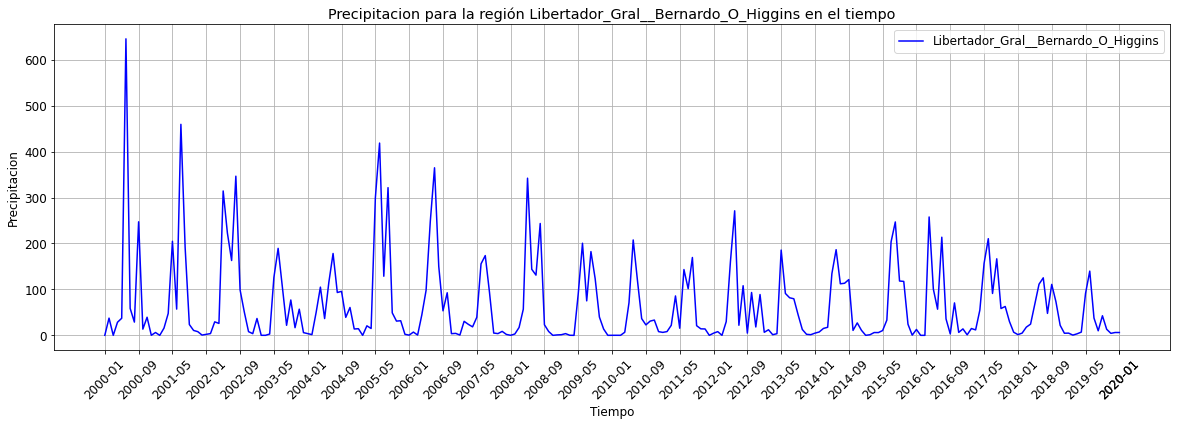

In [57]:
time_series_precipitation("Libertador_Gral__Bernardo_O_Higgins", "2000-01" , "2020-01")

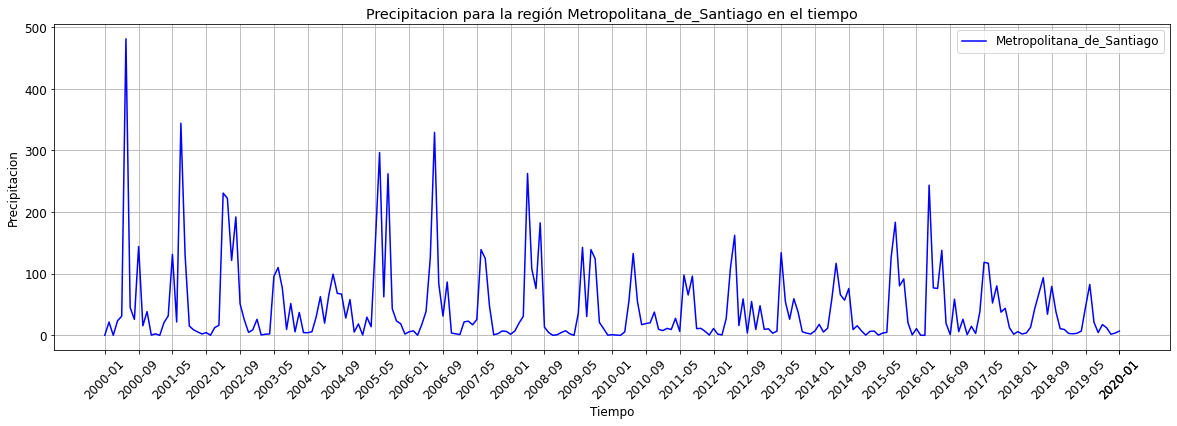

In [58]:
time_series_precipitation("Metropolitana_de_Santiago", "2000-01" , "2020-01")

Observando las gráficas de Metropolitana y Libertador, se observa que son ciclicas, es decir, que existe un aumento y reducción de la precipitacion,más no se observa que haya un mes específico del año en que sucedan los picos de precipitación. Además hay una tendencia clara a la reducción de la precipitación por año, lo que se observa en la reducciónd e los picos a través del tiempo



---



---



Crea una función que, para una región, grafique múltiples series de tiempo
mensuales de precipitaciones, donde cada serie de tiempo corresponda a un año. La
función debe recibir como argumento una lista con los años que queremos graficar
(2000, 2005,..) y el nombre de la región. El eje X debe indicar los meses (enero,
febrero, etc…).

Usa esta función para graficar las precipitaciones para la Región del Maule durante
los años 1982, 1992, 2002, 2012 y 2019.
* ¿Qué puedes concluir de estos gráficos?

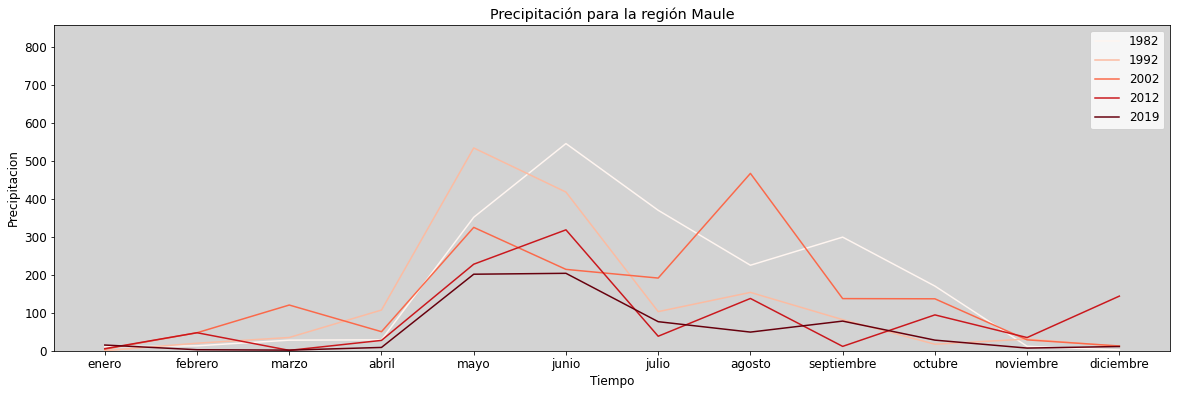

In [59]:
def time_series_year_region(yearList, region_name):

  region_names = precipitation.columns[1:]
  available_years = [str(year) for year in range(1979,2021)]
  monthList = ["enero", "febrero", "marzo", "abril", "mayo", "junio", "julio", "agosto", "septiembre", "octubre", "noviembre", "diciembre"]

  if (region_name not in region_names):
    return print('El nombre de región {} no es un nombre valido, verifique los nombres de regiones disponibles'.format(region_name))

  for year in yearList:
    if (year not in available_years):
      return print('El año {} no es un año valido, verifique los años disponibles'.format(year))

  colors=iter(cm.Reds(np.linspace(0,1,len(yearList))))
  plt.rc('font', size=12)
  fig, ax = plt.subplots(figsize=(20, 6))
  ax.set_xlabel('Tiempo')
  ax.set_ylabel('Precipitacion')
  ax.set_title(f"Precipitación para la región {region_name}") 
  ax.set_facecolor('lightgray')
  
  plt.ylim([0, precipitation[region_name].max() + 100])

  for year in yearList: 
     start_idx = precipitation.index[(precipitation['Fecha'].str.contains(year))][0]
     end_idx = precipitation.index[(precipitation['Fecha'].str.contains(year))][-1]
     
     y = precipitation[region_name][start_idx:end_idx+1].tolist()

     # Specify how our lines should look
     ax.plot(monthList, y, color=next(colors), label=year)
     plt.legend()

  plt.show()
 
time_series_year_region(["1982", "1992", "2002", "2012", "2019"], "Maule")


Se puede deducir que para esta región las precipitaciones aumentan considerablemente a partir del mes de abril, además se observa que a traves del tiempo la precipitación promedio anual se reduce, siendo los valores maximos en los años de 1982 y 1992 y siendo los más bajos en los años 2012 y 2019



---



---



Crea una función que permita visualizar dos series históricas de PIB para un rango de
fechas determinado. Para esto la función debe recibir como input el nombre de cada
serie, fecha de inicio y fecha de término.

Para esto se hará la suposición de que los valores atipicos seran interpretados como millones, aunque se contradice de lo dicho anteriormente

In [60]:
banco = pd.read_csv('./data/banco_central.csv')
banco["Periodo"] = banco["Periodo"].astype(str)
f = lambda x: x.split("-")[0] + "-" +  x.split("-")[1]
banco["Periodo"] = banco["Periodo"].apply(f)
banco.head()

,Periodo,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,Imacec_resto_de_bienes,Imacec_comercio,Imacec_servicios,Imacec_a_costo_de_factores,Imacec_no_minero,...,Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100,Indice_de_produccion_industrial,Indice_de_produccion_industrial__mineria,Indice_de_produccion_industrial_electricidad__gas_y_agua,Indice_de_produccion_industrial__manufacturera,Generacion_de_energia_electrica_CDEC_GWh,Indice_de_ventas_comercio_real_IVCM,Indice_de_ventas_comercio_real_no_durables_IVCM,Indice_de_ventas_comercio_real_durables_IVCM,Ventas_autos_nuevos
0,2013-03,102.796.218,10.546.824,978.554.365,102.297.537,114.994.919,110.729.395,100.064.328,103.163.651,103.405.852,...,865.903.468,102.761.705,98.915.705,NaN,108.387.837,580.480.672,NaN,NaN,NaN,28577.0
1,2013-04,101.664.842,999.272.757,927.333.293,104.485.589,102.199.311,106.098.291,102.600.107,101.937.319,102.766.884,...,867.806.065,968.087.179,914.276.663,NaN,104.545.429,544.815.032,NaN,NaN,NaN,32206.0
2,2013-05,101.642.954,993.959.922,96.133.164,105.445.361,968.789.055,100.462.117,104.083.216,101.953.299,102.322.796,...,878.030.947,978.471.874,966.913.278,NaN,99.468.801,56.891.916,NaN,NaN,NaN,31589.0
3,2013-06,998.310.201,968.367.884,102.400.933,999.212.106,89.190.493,939.504.414,103.857.161,100.222.381,995.139.235,...,913.180.348,966.647.135,981.820.974,NaN,94.969.678,56.594.867,NaN,NaN,NaN,28457.0
4,2013-07,964.696.194,961.051.418,980.029.022,100.882.112,901.785.886,92.776.599,969.309.272,962.069.134,962.804.305,...,909.263.447,100.100.749,990.198.382,NaN,102.128.977,586.329.899,NaN,NaN,NaN,31736.0


In [61]:
banco.tail()

,Periodo,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,Imacec_resto_de_bienes,Imacec_comercio,Imacec_servicios,Imacec_a_costo_de_factores,Imacec_no_minero,...,Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100,Indice_de_produccion_industrial,Indice_de_produccion_industrial__mineria,Indice_de_produccion_industrial_electricidad__gas_y_agua,Indice_de_produccion_industrial__manufacturera,Generacion_de_energia_electrica_CDEC_GWh,Indice_de_ventas_comercio_real_IVCM,Indice_de_ventas_comercio_real_no_durables_IVCM,Indice_de_ventas_comercio_real_durables_IVCM,Ventas_autos_nuevos
609,2008-08,792.872.358,809.540.557,844.433.727,862.655.599,721.027.743,640.625.573,829.163.596,799.073.886,786.659.097,...,99.298.129,NaN,847.665.895,NaN,905.764.363,475.746.478,NaN,NaN,NaN,NaN
610,2008-09,786.802.278,814.228.983,875.931.483,85.990.071,693.602.068,629.581.947,810.645.789,791.396.405,772.867.447,...,972.530.264,NaN,859.131.907,NaN,894.789.858,453.055.435,NaN,NaN,NaN,NaN
611,2008-10,841.834.519,896.565.998,980.164.017,889.145.021,79.386.738,653.517.611,856.040.952,85.038.187,818.131.883,...,105.609.319,NaN,902.538.952,NaN,981.854.401,478.309.081,NaN,NaN,NaN,NaN
612,2008-11,82.846.325,845.666.687,864.252.442,83.063.253,843.834.773,638.884.202,881.094.389,838.436.575,825.672.572,...,10.738.286,NaN,877.968.927,NaN,914.543.986,466.174.958,NaN,NaN,NaN,NaN
613,2008-12,881.247.458,983.189.901,10.705.794,888.736.894,955.925.017,810.432.344,820.841.346,887.995.505,847.322.725,...,107.490.006,NaN,959.869.013,NaN,934.298.114,487.878.953,NaN,NaN,NaN,NaN


In [62]:
banco = banco.sort_values(by=['Periodo']).reset_index(drop=True)
banco = banco[["Periodo", "PIB_Agropecuario_silvicola", 'PIB_Servicios_financieros']]
banco[banco.Periodo == "2013-01"]

,Periodo,PIB_Agropecuario_silvicola,PIB_Servicios_financieros
516,2013-01,555.875.498,571.866.642


In [63]:
banco = banco[516:]

In [64]:
banco = banco.dropna()

In [65]:
changeColumn = lambda x: int(x.split(".")[0]+x.split(".")[1]+x.split(".")[2])
banco.PIB_Agropecuario_silvicola = banco.PIB_Agropecuario_silvicola.apply(changeColumn)
banco.PIB_Servicios_financieros = banco.PIB_Servicios_financieros.apply(changeColumn)

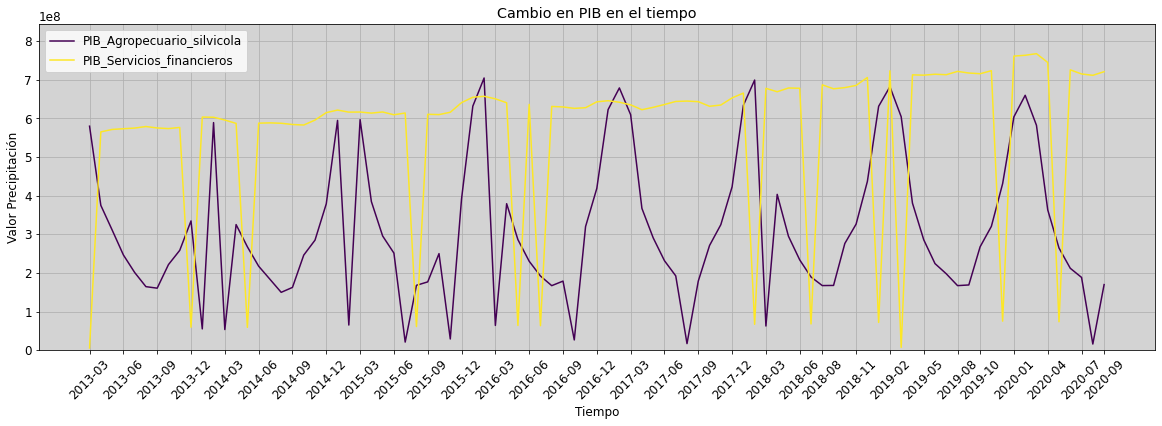

In [66]:
def time_series_PIB(PIB1, PIB2, start_date, end_date):

  available_dates = banco.Periodo.tolist()
  
  if (PIB1 not in banco.columns):
    return print(f"El PIB {PIB1} no está entre los PIB disponibles")
  if (PIB2 not in banco.columns):
    return print(f"El PIB {PIB2} no está entre los PIB disponibles")

  if (start_date not in available_dates):
    return print('La fecha de inicio {} no es una fecha valida'.format(start_date))
  if (end_date not in available_dates):
    return print('La fecha de finalización {} no es una fecha valida'.format(end_date))
  if (datetime.strptime(start_date, '%Y-%m')> datetime.strptime(end_date, '%Y-%m')):
    return print("Las fecha inicial debe ser anterior a la fecha final")

  colors=iter(cm.viridis(np.linspace(0,1,2)))
  plt.rc('font', size=12)
  fig, ax = plt.subplots(figsize=(20, 6))
  ax.set_xlabel('Tiempo')
  ax.set_ylabel('Valor Precipitación')
  ax.set_title("Cambio en PIB en el tiempo") 
  ax.set_facecolor('lightgray')
  
  plt.ylim([0, max(banco[PIB1].max(),banco[PIB2].max())*1.1 ])
  start_idx = banco.index[banco['Periodo'] == start_date].tolist()[0]
  end_idx = banco.index[banco['Periodo'] == end_date].tolist()[0]
  x = banco.Periodo.loc[start_idx:end_idx+1].tolist()


  for PIB in [PIB1, PIB2]:

    y = banco[PIB].loc[start_idx:end_idx+1].tolist()
    ax.plot(x, y, color=next(colors), label=PIB)

    # Same as above
   
    ax.grid(True)
    k = int(len(x)/30)
    labels = x[::k]
    labels = np.append(labels, end_date)
    plt.xticks(labels, rotation='45')
    ax.legend(loc='upper left')
   

time_series_PIB("PIB_Agropecuario_silvicola", "PIB_Servicios_financieros", "2013-03", "2020-09")

  

  


* La serie del PIB Agropecuario Silvícola es ciclica a partir del año 2015, ya que previamente contaba con picos que no presentaban un comportamiento cíclico , mientras el PIB de Servicios Financieros tiene un comportamiento donde  hay ciclos pero que no mantienen un rango de tiempo similar entre sí, ya que existen puntos donde el PIB se mantiene constante por años, mientras en otros puntos llega a caer en cuestión de meses.

* Se observa que las series estan relacionadas, de tal manera que cuando en el PIB de servicios financieros se alcanza un estado estable en alrededor 6e8, el PIB Agropecuario Silvicola comienza a tener picos que tratan de alcanzar el máximo establecido por el PIB financiero

###  Pregunta 4: 

¿Cómo podríamos evaluar la correlación entre las distintas series de tiempo y cómo
se tienen que correlacionar para entrenar un modelo? ¿Mucha correlación, no
correlacionadas, da igual?

Respuesta: 

* Deberia existir una correlación entre la entrada y la salida a predecir, si las series de tiempo definidas no cuentan con una correlación con la variable de precio de la leche, no se tendra un modelo que sea capaz de predecir correctamente el comportamiento de dicha variable.

* La correlación entre las series de tiempo puede ser evaluada mediante el usó de matrices de correlación, observando como se relacionan las distintas variables, aquellas más correlacionadas (y que no sean rezagos o lag de una misma variable) pueden ser consideradas como variables óptimas para la creación de un modelo, otra forma adecuada de visualizar la correlacióne es graficamente, se pueden comparar varias series de tiempo en un mismo rango de fechas, y así observar si tienen una relación visible entre ellas

In [67]:
milk_data.head()

,Fecha,Precio_leche
0,1979-01,3.85
1,1979-02,4.58
2,1979-03,5.18
3,1979-04,6.06
4,1979-05,7.25


In [68]:
precipitation.head()

,Fecha,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios
0,1979-01,2.641948,0.587062,2.447114,1.608992,3.736215,17.859634,25.212940,45.596447
1,1979-02,1.179804,2.432192,3.997852,4.346310,16.347637,17.680612,18.085072,34.075039
2,1979-03,0.255490,0.020601,0.000000,0.055488,0.545324,14.435698,28.696504,66.232248
3,1979-04,10.173699,11.745779,13.722349,12.989194,21.880607,39.136483,43.617921,73.548127
4,1979-05,1.039098,18.609286,50.187148,104.451550,143.914334,219.729235,279.409718,438.005116


In [69]:
Final_central_bank.head()

,Fecha,Precio_de_la_onza_troy_de_oro_dolaresoz,Precio_de_la_onza_troy_de_plata_dolaresoz,Precio_del_petroleo_WTI_dolaresbarril
0,1983-05,438.01,12.98,30.1
1,1983-06,412.84,11.75,31.0
2,1983-07,422.72,12.09,31.6
3,1983-08,416.68,12.10,31.9
4,1983-09,411.80,11.91,31.2


In [70]:
df = milk_data.merge(precipitation, on="Fecha", how="left")
df.head()

,Fecha,Precio_leche,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios
0,1979-01,3.85,2.641948,0.587062,2.447114,1.608992,3.736215,17.859634,25.212940,45.596447
1,1979-02,4.58,1.179804,2.432192,3.997852,4.346310,16.347637,17.680612,18.085072,34.075039
2,1979-03,5.18,0.255490,0.020601,0.000000,0.055488,0.545324,14.435698,28.696504,66.232248
3,1979-04,6.06,10.173699,11.745779,13.722349,12.989194,21.880607,39.136483,43.617921,73.548127
4,1979-05,7.25,1.039098,18.609286,50.187148,104.451550,143.914334,219.729235,279.409718,438.005116


In [71]:
timeseries_df = df.merge(Final_central_bank, on="Fecha", how="left")
timeseries_df.head()

,Fecha,Precio_leche,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios,Precio_de_la_onza_troy_de_oro_dolaresoz,Precio_de_la_onza_troy_de_plata_dolaresoz,Precio_del_petroleo_WTI_dolaresbarril
0,1979-01,3.85,2.641948,0.587062,2.447114,1.608992,3.736215,17.859634,25.212940,45.596447,NaN,NaN,NaN
1,1979-02,4.58,1.179804,2.432192,3.997852,4.346310,16.347637,17.680612,18.085072,34.075039,NaN,NaN,NaN
2,1979-03,5.18,0.255490,0.020601,0.000000,0.055488,0.545324,14.435698,28.696504,66.232248,NaN,NaN,NaN
3,1979-04,6.06,10.173699,11.745779,13.722349,12.989194,21.880607,39.136483,43.617921,73.548127,NaN,NaN,NaN
4,1979-05,7.25,1.039098,18.609286,50.187148,104.451550,143.914334,219.729235,279.409718,438.005116,NaN,NaN,NaN


In [72]:
timeseries_df = timeseries_df.dropna(how="any")

Creación de dataset con merge en datos de precipitación y datos de Banco Central

In [73]:
timeseries_df

,Fecha,Precio_leche,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios,Precio_de_la_onza_troy_de_oro_dolaresoz,Precio_de_la_onza_troy_de_plata_dolaresoz,Precio_del_petroleo_WTI_dolaresbarril
52,1983-05,11.70,19.197529,55.973961,80.120587,121.873659,162.240574,179.154083,193.299109,226.423592,438.01,12.980,30.10
53,1983-06,12.02,24.177745,106.585763,147.340872,212.603783,305.955516,326.590386,292.038050,333.025853,412.84,11.750,31.00
54,1983-07,12.37,113.785497,157.110471,184.828473,215.065179,256.860516,264.963138,264.500069,324.252739,422.72,12.090,31.60
55,1983-08,12.07,70.087392,102.761705,99.913523,141.555225,176.974426,212.224661,204.448423,273.193269,416.68,12.100,31.90
56,1983-09,11.41,11.138196,26.274318,50.929346,72.709380,85.390125,125.519495,165.941112,275.676421,411.80,11.910,31.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,2019-12,253.86,0.287895,0.165390,3.601443,6.198806,11.327313,14.014122,27.321858,62.170090,1482.83,171.946,59.80
494,2020-01,254.10,3.299797,2.003685,6.937148,6.154279,7.875591,19.518225,35.916618,63.389625,1559.64,179.557,57.52
495,2020-02,270.15,0.179216,0.003701,0.032064,0.017628,0.200483,10.108504,29.001988,55.838889,1595.63,178.426,50.53
496,2020-03,279.88,0.003451,0.000666,0.000000,0.000000,0.115566,12.462699,28.310937,73.640866,1592.92,149.237,29.88


Se crean variables con lag, de 1 y 2 meses para cada variable, y para la variable de precio de la leche se crea la variable objetivo, precio del proximo més, con esto se tiene el set de datos apropiado para crear un modelo de predicción

In [74]:
# Retraso de 1 y 2 periodos para cada variable

timeseries_withLag = timeseries_df.copy()
for column in timeseries_withLag.columns[1:]:
  timeseries_withLag[f"{column}_last_month"] = timeseries_withLag[column].shift(1, axis = 0)
  timeseries_withLag[f"{column}_two_months_before"] = timeseries_withLag[column].shift(2, axis = 0)


#Columna del precio de la leche el mes siguiente

timeseries_withLag["Precio_leche_next_month"] = timeseries_withLag["Precio_leche"].shift(-1, axis = 0)


In [75]:
timeseries_withLag.tail()

,Fecha,Precio_leche,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios,...,La_Araucania_two_months_before,Los_Rios_last_month,Los_Rios_two_months_before,Precio_de_la_onza_troy_de_oro_dolaresoz_last_month,Precio_de_la_onza_troy_de_oro_dolaresoz_two_months_before,Precio_de_la_onza_troy_de_plata_dolaresoz_last_month,Precio_de_la_onza_troy_de_plata_dolaresoz_two_months_before,Precio_del_petroleo_WTI_dolaresbarril_last_month,Precio_del_petroleo_WTI_dolaresbarril_two_months_before,Precio_leche_next_month
493,2019-12,253.86,0.287895,0.165390,3.601443,6.198806,11.327313,14.014122,27.321858,62.170090,...,94.371158,133.271809,135.689393,1470.21,1494.96,171.559,176.326,57.06,53.98,254.10
494,2020-01,254.10,3.299797,2.003685,6.937148,6.154279,7.875591,19.518225,35.916618,63.389625,...,66.545126,62.170090,133.271809,1482.83,1470.21,171.946,171.559,59.80,57.06,270.15
495,2020-02,270.15,0.179216,0.003701,0.032064,0.017628,0.200483,10.108504,29.001988,55.838889,...,27.321858,63.389625,62.170090,1559.64,1482.83,179.557,171.946,57.52,59.80,279.88
496,2020-03,279.88,0.003451,0.000666,0.000000,0.000000,0.115566,12.462699,28.310937,73.640866,...,35.916618,55.838889,63.389625,1595.63,1559.64,178.426,179.557,50.53,57.52,316.25
497,2020-04,316.25,0.556085,4.664708,16.033775,19.795752,37.348511,66.764275,73.813290,140.076757,...,29.001988,73.640866,55.838889,1592.92,1595.63,149.237,178.426,29.88,50.53,NaN


In [76]:
timeseries_withLag

,Fecha,Precio_leche,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios,...,La_Araucania_two_months_before,Los_Rios_last_month,Los_Rios_two_months_before,Precio_de_la_onza_troy_de_oro_dolaresoz_last_month,Precio_de_la_onza_troy_de_oro_dolaresoz_two_months_before,Precio_de_la_onza_troy_de_plata_dolaresoz_last_month,Precio_de_la_onza_troy_de_plata_dolaresoz_two_months_before,Precio_del_petroleo_WTI_dolaresbarril_last_month,Precio_del_petroleo_WTI_dolaresbarril_two_months_before,Precio_leche_next_month
52,1983-05,11.70,19.197529,55.973961,80.120587,121.873659,162.240574,179.154083,193.299109,226.423592,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.02
53,1983-06,12.02,24.177745,106.585763,147.340872,212.603783,305.955516,326.590386,292.038050,333.025853,...,NaN,226.423592,NaN,438.01,NaN,12.980,NaN,30.10,NaN,12.37
54,1983-07,12.37,113.785497,157.110471,184.828473,215.065179,256.860516,264.963138,264.500069,324.252739,...,193.299109,333.025853,226.423592,412.84,438.01,11.750,12.980,31.00,30.10,12.07
55,1983-08,12.07,70.087392,102.761705,99.913523,141.555225,176.974426,212.224661,204.448423,273.193269,...,292.038050,324.252739,333.025853,422.72,412.84,12.090,11.750,31.60,31.00,11.41
56,1983-09,11.41,11.138196,26.274318,50.929346,72.709380,85.390125,125.519495,165.941112,275.676421,...,264.500069,273.193269,324.252739,416.68,422.72,12.100,12.090,31.90,31.60,10.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,2019-12,253.86,0.287895,0.165390,3.601443,6.198806,11.327313,14.014122,27.321858,62.170090,...,94.371158,133.271809,135.689393,1470.21,1494.96,171.559,176.326,57.06,53.98,254.10
494,2020-01,254.10,3.299797,2.003685,6.937148,6.154279,7.875591,19.518225,35.916618,63.389625,...,66.545126,62.170090,133.271809,1482.83,1470.21,171.946,171.559,59.80,57.06,270.15
495,2020-02,270.15,0.179216,0.003701,0.032064,0.017628,0.200483,10.108504,29.001988,55.838889,...,27.321858,63.389625,62.170090,1559.64,1482.83,179.557,171.946,57.52,59.80,279.88
496,2020-03,279.88,0.003451,0.000666,0.000000,0.000000,0.115566,12.462699,28.310937,73.640866,...,35.916618,55.838889,63.389625,1595.63,1559.64,178.426,179.557,50.53,57.52,316.25


Se convierte la columna fecha a tipo DateTime de Pandas, para asi crear las respectivas columnas de "Trimestre", "Mes" y "Año" (se mantiene la nomenclatura de "Anio" para evitar algún posible error de lectura por parte de los encargados de revisar el reto

In [77]:
timeseries_withLag["Fecha"] = pd.to_datetime(timeseries_withLag["Fecha"], format="%Y-%m" )

In [78]:
timeseries_withLag["Trimestre"] =  timeseries_withLag.Fecha.dt.quarter
timeseries_withLag["Mes"] = timeseries_withLag.Fecha.dt.month_name()
timeseries_withLag["Anio"] = timeseries_withLag.Fecha.dt.year

In [79]:
timeseries_withLag = timeseries_withLag.dropna(how="any")

In [80]:
timeseries_withLag = timeseries_withLag.reset_index(drop=True)

In [81]:
timeseries_withLag.head(10)

,Fecha,Precio_leche,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios,...,Precio_de_la_onza_troy_de_oro_dolaresoz_last_month,Precio_de_la_onza_troy_de_oro_dolaresoz_two_months_before,Precio_de_la_onza_troy_de_plata_dolaresoz_last_month,Precio_de_la_onza_troy_de_plata_dolaresoz_two_months_before,Precio_del_petroleo_WTI_dolaresbarril_last_month,Precio_del_petroleo_WTI_dolaresbarril_two_months_before,Precio_leche_next_month,Trimestre,Mes,Anio
0,1983-07-01,12.37,113.785497,157.110471,184.828473,215.065179,256.860516,264.963138,264.500069,324.252739,...,412.84,438.01,11.75,12.98,31.0,30.1,12.07,3,July,1983
1,1983-08-01,12.07,70.087392,102.761705,99.913523,141.555225,176.974426,212.224661,204.448423,273.193269,...,422.72,412.84,12.09,11.75,31.6,31.0,11.41,3,August,1983
2,1983-09-01,11.41,11.138196,26.274318,50.929346,72.709380,85.390125,125.519495,165.941112,275.676421,...,416.68,422.72,12.10,12.09,31.9,31.6,10.59,3,September,1983
3,1983-10-01,10.59,0.250575,0.528815,7.698255,9.627132,11.910774,46.606150,97.956474,134.936847,...,411.80,416.68,11.91,12.10,31.2,31.9,9.86,4,October,1983
4,1983-11-01,9.86,0.383190,0.130584,0.229211,0.594403,1.871681,2.301177,5.294905,17.266731,...,393.58,411.80,9.84,11.91,30.4,31.2,10.04,4,November,1983
5,1983-12-01,10.04,0.540072,0.000000,0.021141,0.689364,4.589584,7.305120,28.036984,40.091654,...,381.69,393.58,8.84,9.84,30.0,30.4,10.95,4,December,1983
6,1984-01-01,10.95,5.008340,2.767662,4.348490,0.593380,7.381780,25.358424,37.271241,87.786253,...,388.34,381.69,9.12,8.84,29.2,30.0,12.37,1,January,1984
7,1984-02-01,12.37,3.084745,0.033295,0.139262,0.338140,9.445674,55.256356,85.390868,132.428682,...,370.92,388.34,8.20,9.12,29.7,29.2,15.56,1,February,1984
8,1984-03-01,15.56,17.093614,13.123831,23.029899,24.961581,24.569534,37.212114,53.190579,73.679832,...,386.22,370.92,9.11,8.20,30.1,29.7,16.69,1,March,1984
9,1984-04-01,16.69,1.575516,4.367987,20.419379,22.212248,36.532537,43.568570,58.544600,118.599173,...,394.25,386.22,9.65,9.11,30.8,30.1,18.72,2,April,1984


In [82]:
timeseries_withLag.describe()

,Precio_leche,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios,Precio_de_la_onza_troy_de_oro_dolaresoz,...,Los_Rios_two_months_before,Precio_de_la_onza_troy_de_oro_dolaresoz_last_month,Precio_de_la_onza_troy_de_oro_dolaresoz_two_months_before,Precio_de_la_onza_troy_de_plata_dolaresoz_last_month,Precio_de_la_onza_troy_de_plata_dolaresoz_two_months_before,Precio_del_petroleo_WTI_dolaresbarril_last_month,Precio_del_petroleo_WTI_dolaresbarril_two_months_before,Precio_leche_next_month,Trimestre,Anio
count,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,...,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000,443.000000
mean,123.528465,16.188164,31.536370,47.677373,69.313225,94.970678,124.764141,148.982583,197.107010,686.566479,...,198.077596,683.902641,681.289503,68.470894,68.097427,43.255666,43.209549,124.214424,2.505643,2001.451467
std,69.881048,33.457542,54.236613,71.188616,96.868718,117.354316,125.889915,123.329631,136.901626,453.030432,...,136.767001,451.154554,449.210121,97.621103,97.515913,28.276412,28.281181,70.277769,1.120294,10.665386
min,9.860000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001170,0.005331,0.748127,256.240000,...,0.748127,256.240000,256.240000,3.650000,3.650000,11.300000,11.300000,9.860000,1.000000,1983.000000
25%,77.455000,0.808389,1.525885,5.248096,5.976047,11.815437,28.967028,52.906672,89.061783,350.020000,...,89.953301,350.020000,350.020000,5.090000,5.090000,19.950000,19.950000,78.295000,1.500000,1992.000000
50%,106.780000,4.000993,8.939481,18.771812,25.954915,46.371464,78.965758,110.215156,158.491137,406.780000,...,159.450982,406.780000,406.780000,6.670000,6.670000,30.300000,30.100000,107.630000,3.000000,2001.000000
75%,191.150000,16.174141,37.690674,60.028624,98.884814,136.458952,179.146789,204.674787,273.254987,1181.000000,...,274.496563,1178.320000,1167.455000,153.489000,152.056500,60.720000,60.720000,191.615000,3.500000,2011.000000
max,279.880000,347.133889,441.048604,481.129715,645.515752,759.177712,702.434707,661.211203,717.735673,1772.000000,...,717.735673,1772.000000,1772.000000,431.028000,431.028000,133.930000,133.930000,316.250000,4.000000,2020.000000


In [83]:
timeseries_withLag = timeseries_withLag.dropna(how="any")

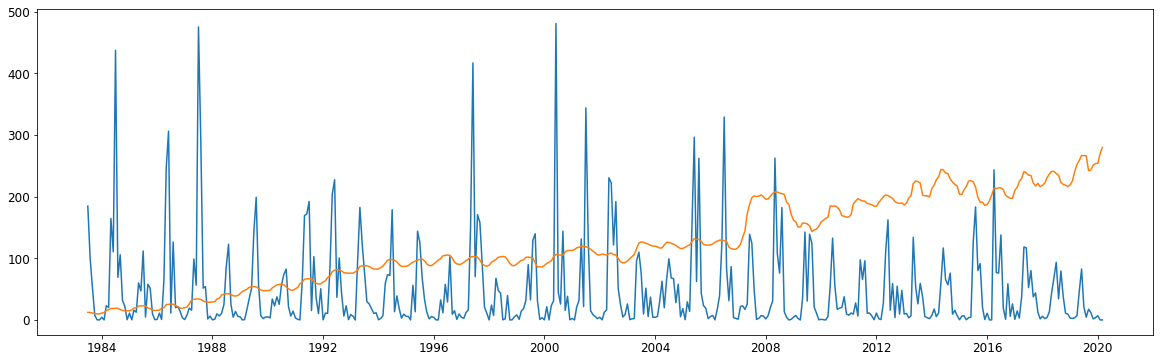

In [84]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(timeseries_withLag.Fecha, timeseries_withLag.Metropolitana_de_Santiago)
ax.plot(timeseries_withLag.Fecha, timeseries_withLag.Precio_leche)

Se obtiene la variable objetivo y se guarda en la variable y, mientras el resto de columnas que harán parte del modelo estarán asociadas a la variable X

In [85]:
y = timeseries_withLag.Precio_leche_next_month

columns_list = [
 'Precio_leche',
 'Coquimbo',
 'Valparaiso',
 'Metropolitana_de_Santiago',
 'Libertador_Gral__Bernardo_O_Higgins',
 'Maule',
 'Biobio',
 'La_Araucania',
 'Los_Rios',
 'Precio_de_la_onza_troy_de_oro_dolaresoz',
 'Precio_de_la_onza_troy_de_plata_dolaresoz',
 'Precio_del_petroleo_WTI_dolaresbarril',
 'Precio_leche_last_month',
 'Precio_leche_two_months_before',
 'Coquimbo_last_month',
 'Coquimbo_two_months_before',
 'Valparaiso_last_month',
 'Valparaiso_two_months_before',
 'Metropolitana_de_Santiago_last_month',
 'Metropolitana_de_Santiago_two_months_before',
 'Libertador_Gral__Bernardo_O_Higgins_last_month',
 'Libertador_Gral__Bernardo_O_Higgins_two_months_before',
 'Maule_last_month',
 'Maule_two_months_before',
 'Biobio_last_month',
 'Biobio_two_months_before',
 'La_Araucania_last_month',
 'La_Araucania_two_months_before',
 'Los_Rios_last_month',
 'Los_Rios_two_months_before',
 'Precio_de_la_onza_troy_de_oro_dolaresoz_last_month',
 'Precio_de_la_onza_troy_de_oro_dolaresoz_two_months_before',
 'Precio_de_la_onza_troy_de_plata_dolaresoz_last_month',
 'Precio_de_la_onza_troy_de_plata_dolaresoz_two_months_before',
 'Precio_del_petroleo_WTI_dolaresbarril_last_month',
 'Precio_del_petroleo_WTI_dolaresbarril_two_months_before',
]

X = timeseries_withLag[columns_list]

In [86]:
X

,Precio_leche,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios,Precio_de_la_onza_troy_de_oro_dolaresoz,...,La_Araucania_last_month,La_Araucania_two_months_before,Los_Rios_last_month,Los_Rios_two_months_before,Precio_de_la_onza_troy_de_oro_dolaresoz_last_month,Precio_de_la_onza_troy_de_oro_dolaresoz_two_months_before,Precio_de_la_onza_troy_de_plata_dolaresoz_last_month,Precio_de_la_onza_troy_de_plata_dolaresoz_two_months_before,Precio_del_petroleo_WTI_dolaresbarril_last_month,Precio_del_petroleo_WTI_dolaresbarril_two_months_before
0,12.37,113.785497,157.110471,184.828473,215.065179,256.860516,264.963138,264.500069,324.252739,422.72,...,292.038050,193.299109,333.025853,226.423592,412.84,438.01,11.750,12.980,31.00,30.10
1,12.07,70.087392,102.761705,99.913523,141.555225,176.974426,212.224661,204.448423,273.193269,416.68,...,264.500069,292.038050,324.252739,333.025853,422.72,412.84,12.090,11.750,31.60,31.00
2,11.41,11.138196,26.274318,50.929346,72.709380,85.390125,125.519495,165.941112,275.676421,411.80,...,204.448423,264.500069,273.193269,324.252739,416.68,422.72,12.100,12.090,31.90,31.60
3,10.59,0.250575,0.528815,7.698255,9.627132,11.910774,46.606150,97.956474,134.936847,393.58,...,165.941112,204.448423,275.676421,273.193269,411.80,416.68,11.910,12.100,31.20,31.90
4,9.86,0.383190,0.130584,0.229211,0.594403,1.871681,2.301177,5.294905,17.266731,381.69,...,97.956474,165.941112,134.936847,275.676421,393.58,411.80,9.840,11.910,30.40,31.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,251.22,0.011588,0.030828,1.810671,4.307132,7.177471,27.668158,66.545126,133.271809,1470.21,...,94.371158,100.461828,135.689393,128.256227,1494.96,1507.95,176.326,181.314,53.98,56.95
439,253.86,0.287895,0.165390,3.601443,6.198806,11.327313,14.014122,27.321858,62.170090,1482.83,...,66.545126,94.371158,133.271809,135.689393,1470.21,1494.96,171.559,176.326,57.06,53.98
440,254.10,3.299797,2.003685,6.937148,6.154279,7.875591,19.518225,35.916618,63.389625,1559.64,...,27.321858,66.545126,62.170090,133.271809,1482.83,1470.21,171.946,171.559,59.80,57.06
441,270.15,0.179216,0.003701,0.032064,0.017628,0.200483,10.108504,29.001988,55.838889,1595.63,...,35.916618,27.321858,63.389625,62.170090,1559.64,1482.83,179.557,171.946,57.52,59.80


In [87]:
y

0       12.07
1       11.41
2       10.59
3        9.86
4       10.04
        ...  
438    253.86
439    254.10
440    270.15
441    279.88
442    316.25
Name: Precio_leche_next_month, Length: 443, dtype: float64

En primera instancia se hará una división aleatoria del dataset, con un tamaño del set de testeo del 20% debido a que la cantidad de datos total es de 443, por lo que una división mayor podria resultar en deficiencia por parte del modelo

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [89]:
for column in X_train.columns:
  scaler = MinMaxScaler()
  X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1,1))
  X_test[column] = scaler.transform(X_test[column].values.reshape(-1,1))

target_scaler = MinMaxScaler()
y_train = target_scaler.fit_transform(y_train.values.reshape(-1,1))
y_test = target_scaler.transform(y_test.values.reshape(-1,1))

In [90]:
X_train

,Precio_leche,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios,Precio_de_la_onza_troy_de_oro_dolaresoz,...,La_Araucania_last_month,La_Araucania_two_months_before,Los_Rios_last_month,Los_Rios_two_months_before,Precio_de_la_onza_troy_de_oro_dolaresoz_last_month,Precio_de_la_onza_troy_de_oro_dolaresoz_two_months_before,Precio_de_la_onza_troy_de_plata_dolaresoz_last_month,Precio_de_la_onza_troy_de_plata_dolaresoz_two_months_before,Precio_del_petroleo_WTI_dolaresbarril_last_month,Precio_del_petroleo_WTI_dolaresbarril_two_months_before
75,0.144952,0.000002,0.000774,0.014277,0.026395,0.039530,0.071895,0.112815,0.143191,0.072993,...,0.117395,0.414432,0.142168,0.489706,0.069609,0.071997,0.003463,0.003580,0.067683,0.059529
120,0.289460,0.065672,0.118106,0.160764,0.169027,0.179045,0.341591,0.503595,0.559486,0.090318,...,0.781997,0.832067,0.774868,0.746288,0.077110,0.074280,0.001708,0.001849,0.063606,0.070130
349,0.694171,0.094447,0.145968,0.122827,0.167324,0.181583,0.227871,0.248008,0.380158,0.906489,...,0.222570,0.653458,0.299581,0.636566,0.882349,0.886869,0.633577,0.057187,0.624643,0.579467
84,0.179283,0.082851,0.116280,0.118499,0.159468,0.159407,0.199928,0.260509,0.356027,0.070123,...,0.391033,0.497135,0.434103,0.574368,0.063394,0.074425,0.002948,0.003299,0.044035,0.057082
269,0.413155,0.000032,0.000008,0.004332,0.003485,0.039509,0.080893,0.093732,0.093341,0.167183,...,0.350018,0.091355,0.426172,0.124127,0.146138,0.140966,0.009936,0.009388,0.383104,0.416374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,0.669876,0.010903,0.003515,0.004238,0.012474,0.062685,0.178896,0.219897,0.308985,0.979964,...,0.132248,0.021769,0.220148,0.064240,0.924223,0.912057,0.713488,0.696627,0.725679,0.711571
359,0.798496,0.029564,0.086830,0.113287,0.141237,0.171694,0.246923,0.312006,0.415207,0.716624,...,0.498310,0.163852,0.568085,0.262193,0.765524,0.810676,0.531717,0.582889,0.680584,0.658240
323,0.646285,0.136509,0.235018,0.276173,0.321701,0.337605,0.460557,0.533191,0.638450,0.645049,...,0.173343,0.067631,0.229950,0.121924,0.626966,0.589447,0.422916,0.416086,0.509092,0.596754
280,0.389304,0.001466,0.000496,0.007711,0.005641,0.005908,0.023708,0.070630,0.123919,0.245395,...,0.296052,0.274487,0.337097,0.290084,0.218207,0.225860,0.018627,0.018606,0.387752,0.428280


In [91]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

modelList = [(Ridge, "Ridge"), (Lasso, "Lasso"), 
             (ElasticNet, "ElasticNet"), 
             (KNeighborsRegressor, "K Nearest Neighbors Regressor"),
             (DecisionTreeRegressor, "Decission Tree Regresssor"), 
             (LinearRegression, "Linear Regression"), 
             (SVR, "Support Vector Machine"), 
             (RandomForestRegressor, "Random Forest")]

df = pd.DataFrame()
name_list = []
TrainingRSME = []
TestingRSME = []
TrainingScore = []
TestingScore= []

def modelFit(regressor , name):
  reg = regressor()
  reg.fit(X_train, y_train)
  y_pred_train = reg.predict(X_train)
  y_pred_text= reg.predict(X_test)
  trainScore = round(mean_squared_error(y_train, y_pred_train, squared=False), 3)
  testScore = round(mean_squared_error(y_test, y_pred_text, squared=False),3)
  trainScore2 = round(reg.score(X_train, y_train)*100,3)
  testScore2 = round(reg.score(X_test, y_test)*100,3)
  name_list.append(name)
  TrainingRSME.append(trainScore)
  TestingRSME.append(testScore)
  TrainingScore.append(trainScore2)
  TestingScore.append(testScore2)

  #print(f"Para el modelo {name}\n Error RMSE Train: {trainScore:.3f}\n Error RSME Test: {testScore:.3f} \n\n")

for model, name in modelList:
  modelFit(model, name)

df["Modelo"] = name_list
df["Train RSME"] = TrainingRSME
df["Test RSME"] = TestingRSME
df["Train Score %"] = TrainingScore
df["Test Score %"] = TestingScore

df.head(10)




,Modelo,Train RSME,Test RSME,Train Score %,Test Score %
0,Ridge,0.021,0.027,99.192,98.622
1,Lasso,0.229,0.229,0.000,-0.124
2,ElasticNet,0.229,0.229,0.000,-0.124
3,K Nearest Neighbors Regressor,0.047,0.048,95.781,95.561
4,Decission Tree Regresssor,0.000,0.025,100.000,98.776
5,Linear Regression,0.012,0.016,99.724,99.518
6,Support Vector Machine,0.060,0.063,93.080,92.433
7,Random Forest,0.007,0.022,99.907,99.081


Se observa que para el dataset elegido se tiene un RSME bajo para los modelos de Arbol de Regresión, y Bosque aleatorio (ambos con valores menores a 0.04 unidades de error, teniendo en cuenta que la variable está estandarizada de 0 a 1, se considera un valor aceptable), asi como también un accuracy mayor del 99% en ambos casos). Para evitar que esto sea un error de aleatoriedad, se procede a realizar un proceso de Cross Validation

In [92]:
# Se define la función que se encargará de estandarizar los valores

def estandarizacion(X_train, X_test, y_train, y_test):
  for column in X_train.columns:
    scaler = MinMaxScaler()
    X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1,1))
    X_test[column] = scaler.transform(X_test[column].values.reshape(-1,1))


  target_scaler = MinMaxScaler()
  y_train = target_scaler.fit_transform(y_train.values.reshape(-1,1))
  y_test = target_scaler.transform(y_test.values.reshape(-1,1))

  return (X_train, X_test, y_train, y_test)



In [93]:
# Se define la misma función de ajuste de modelo, ahora recibiendo como parametros los datasets de entrenamiento y testeo
def modelFit(regressor, list_name_train, list_name_test , list2_name_train, list2_name_test , X_train, X_test, y_train, y_test):
  reg = regressor()
  reg.fit(X_train, y_train)
  y_pred_train = reg.predict(X_train)
  y_pred_text= reg.predict(X_test)
  trainScore = round(mean_squared_error(y_train, y_pred_train, squared=False), 3)
  testScore = round(mean_squared_error(y_test, y_pred_text, squared=False),3)
  trainScore2 = round(reg.score(X_train, y_train)*100,3)
  testScore2 = round(reg.score(X_test, y_test)*100,3)
  #name_list.append(name)
  list_name_train.append(trainScore)
  list_name_test.append(testScore)
  list2_name_train.append(trainScore2)
  list2_name_test.append(testScore2)


In [94]:
#Se usa la libreria de KFold cross validation, para separar el set de datos en 10 partes y asi realizar el proceso de entrenamiento y reducir la varianza
from sklearn.model_selection import KFold
folds = KFold(n_splits=10, random_state=42, shuffle=True)

In [95]:
RSME_decision_tree_train = []
RSME_decision_tree_test = []
RSME_random_forest_train = []
RSME_random_forest_test = []
Acc_decision_tree_train = []
Acc_decision_tree_test = []
Acc_random_forest_train = []
Acc_random_forest_test = []

for train_idx, test_idx in folds.split(X):
  
  X_trainf , X_testf, y_trainf, y_testf = X[X.index.isin(train_idx)], X[X.index.isin(test_idx)] , y[y.index.isin(train_idx)], y[y.index.isin(test_idx)]
  X_trainf , X_testf, y_trainf, y_testf = estandarizacion(X_trainf , X_testf, y_trainf, y_testf)
  modelFit(DecisionTreeRegressor, 
           RSME_decision_tree_train,
           RSME_decision_tree_test,
           Acc_decision_tree_train ,
           Acc_decision_tree_test,
           X_trainf, X_testf, y_trainf, y_testf)
  modelFit(RandomForestRegressor, RSME_random_forest_train, 
           RSME_random_forest_test,
           Acc_random_forest_train,
           Acc_random_forest_test,
           X_trainf, X_testf, y_trainf, y_testf)

In [96]:
import statistics
print(f'El promedio de RMSE para 10 crossValidations en arbol de regresión en training es {statistics.mean(RSME_decision_tree_train):} \n')
print(f'El promedio de RMSE para 10 crossValidations en arbol de regresión en testing es {statistics.mean(RSME_decision_tree_test):} \n')
print(f'El promedio de RMSE para 10 crossValidations en bosque aleatorio en training es {statistics.mean(RSME_random_forest_train)} \n')
print(f'El promedio de RMSE para 10 crossValidations en bosque aleatorio en testing es {statistics.mean(RSME_random_forest_test)} \n')
print(f'El promedio de Accuracy para 10 crossValidations en arbol de regresión en training es {statistics.mean(Acc_decision_tree_train):.3f}% \n')
print(f'El promedio de Accuracy para 10 crossValidations en arbol de regresión en testing es {statistics.mean(Acc_decision_tree_test):.3f}% \n')
print(f'El promedio de Accuracy para 10 crossValidations en bosque aleatorio en training es {statistics.mean(Acc_random_forest_train):.3f}% \n')
print(f'El promedio de Accuracy para 10 crossValidations en bosque aleatorio en testing es {statistics.mean(Acc_random_forest_test):.3f}% \n')


El promedio de RMSE para 10 crossValidations en arbol de regresión en training es 0.0 

El promedio de RMSE para 10 crossValidations en arbol de regresión en testing es 0.0252 

El promedio de RMSE para 10 crossValidations en bosque aleatorio en training es 0.0072 

El promedio de RMSE para 10 crossValidations en bosque aleatorio en testing es 0.0174 

El promedio de Accuracy para 10 crossValidations en arbol de regresión en training es 100.000% 

El promedio de Accuracy para 10 crossValidations en arbol de regresión en testing es 98.755% 

El promedio de Accuracy para 10 crossValidations en bosque aleatorio en training es 99.904% 

El promedio de Accuracy para 10 crossValidations en bosque aleatorio en testing es 99.364% 



Por último se hará una división temporal, es decir, se tomará el 80% inicial de los datos en orden para entrenamiento, y el 20% final para testing, para asi observar como se comporta el modelo cuando los datos estan en orden cronológico

In [97]:
split_idx = round(0.8*len(X))

X_train_time = X.iloc[:split_idx]
X_test_time = X.iloc[split_idx:]
y_train_time = y.iloc[:split_idx] 
y_test_time = y.iloc[split_idx:] 

In [98]:
X_train_time


,Precio_leche,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios,Precio_de_la_onza_troy_de_oro_dolaresoz,...,La_Araucania_last_month,La_Araucania_two_months_before,Los_Rios_last_month,Los_Rios_two_months_before,Precio_de_la_onza_troy_de_oro_dolaresoz_last_month,Precio_de_la_onza_troy_de_oro_dolaresoz_two_months_before,Precio_de_la_onza_troy_de_plata_dolaresoz_last_month,Precio_de_la_onza_troy_de_plata_dolaresoz_two_months_before,Precio_del_petroleo_WTI_dolaresbarril_last_month,Precio_del_petroleo_WTI_dolaresbarril_two_months_before
0,12.37,113.785497,157.110471,184.828473,215.065179,256.860516,264.963138,264.500069,324.252739,422.72,...,292.038050,193.299109,333.025853,226.423592,412.84,438.01,11.750,12.980,31.00,30.10
1,12.07,70.087392,102.761705,99.913523,141.555225,176.974426,212.224661,204.448423,273.193269,416.68,...,264.500069,292.038050,324.252739,333.025853,422.72,412.84,12.090,11.750,31.60,31.00
2,11.41,11.138196,26.274318,50.929346,72.709380,85.390125,125.519495,165.941112,275.676421,411.80,...,204.448423,264.500069,273.193269,324.252739,416.68,422.72,12.100,12.090,31.90,31.60
3,10.59,0.250575,0.528815,7.698255,9.627132,11.910774,46.606150,97.956474,134.936847,393.58,...,165.941112,204.448423,275.676421,273.193269,411.80,416.68,11.910,12.100,31.20,31.90
4,9.86,0.383190,0.130584,0.229211,0.594403,1.871681,2.301177,5.294905,17.266731,381.69,...,97.956474,165.941112,134.936847,275.676421,393.58,411.80,9.840,11.910,30.40,31.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,197.30,32.785876,64.378994,59.095839,108.010372,137.855416,160.114003,164.482833,273.316705,1630.26,...,129.112666,379.060510,201.611021,426.488863,1593.67,1600.52,274.427,28.100,87.90,82.36
350,191.97,2.633105,5.463312,3.799211,4.876403,11.656697,39.291496,91.241340,140.012778,1745.78,...,164.482833,129.112666,273.316705,201.611021,1630.26,1593.67,289.697,274.427,94.11,87.90
351,190.03,7.246876,38.218912,54.831460,93.273829,94.590333,66.456536,77.277449,91.480026,1744.36,...,91.241340,164.482833,140.012778,273.316705,1745.78,1630.26,338.057,289.697,94.51,94.11
352,189.21,0.384386,4.251412,9.505403,18.218512,34.894617,53.723783,42.884631,53.415362,1722.89,...,77.277449,91.241340,91.480026,140.012778,1744.36,1745.78,331.488,338.057,89.52,94.51


In [99]:
X_test_time

,Precio_leche,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios,Precio_de_la_onza_troy_de_oro_dolaresoz,...,La_Araucania_last_month,La_Araucania_two_months_before,Los_Rios_last_month,Los_Rios_two_months_before,Precio_de_la_onza_troy_de_oro_dolaresoz_last_month,Precio_de_la_onza_troy_de_oro_dolaresoz_two_months_before,Precio_de_la_onza_troy_de_plata_dolaresoz_last_month,Precio_de_la_onza_troy_de_plata_dolaresoz_two_months_before,Precio_del_petroleo_WTI_dolaresbarril_last_month,Precio_del_petroleo_WTI_dolaresbarril_two_months_before
354,186.63,10.155732,9.476023,9.722886,6.645054,7.531215,10.610359,21.286717,36.419186,1671.28,...,253.288919,42.884631,387.554703,53.415362,1683.41,1722.89,316.815,328.324,88.19,86.68
355,189.52,2.662333,3.329740,10.572315,12.139349,39.104867,49.439734,84.571386,161.760892,1626.92,...,21.286717,253.288919,36.419186,387.554703,1671.28,1683.41,311.596,316.815,94.74,88.19
356,197.60,0.282052,2.228588,3.500923,1.394124,4.366248,11.977028,36.493313,73.323954,1593.60,...,84.571386,21.286717,161.760892,36.419186,1626.92,1671.28,302.232,311.596,95.27,94.74
357,201.70,0.142111,1.629529,6.723540,3.577488,10.806847,42.941649,95.051980,176.105375,1485.03,...,36.493313,84.571386,73.323954,161.760892,1593.60,1626.92,288.157,302.232,92.91,95.27
358,221.60,59.775399,114.732581,134.130436,185.615613,234.374501,288.971343,289.062544,380.996731,1416.59,...,95.051980,36.493313,176.105375,73.323954,1485.03,1593.60,252.768,288.157,92.02,92.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,251.22,0.011588,0.030828,1.810671,4.307132,7.177471,27.668158,66.545126,133.271809,1470.21,...,94.371158,100.461828,135.689393,128.256227,1494.96,1507.95,176.326,181.314,53.98,56.95
439,253.86,0.287895,0.165390,3.601443,6.198806,11.327313,14.014122,27.321858,62.170090,1482.83,...,66.545126,94.371158,133.271809,135.689393,1470.21,1494.96,171.559,176.326,57.06,53.98
440,254.10,3.299797,2.003685,6.937148,6.154279,7.875591,19.518225,35.916618,63.389625,1559.64,...,27.321858,66.545126,62.170090,133.271809,1482.83,1470.21,171.946,171.559,59.80,57.06
441,270.15,0.179216,0.003701,0.032064,0.017628,0.200483,10.108504,29.001988,55.838889,1595.63,...,35.916618,27.321858,63.389625,62.170090,1559.64,1482.83,179.557,171.946,57.52,59.80


In [100]:
X_train_time , X_test_time, y_train_time, y_test_time = estandarizacion(X_train_time , X_test_time, y_train_time, y_test_time)

In [101]:
RSME_decision_tree_train_time = []
RSME_decision_tree_test_time = []
RSME_random_forest_train_time = []
RSME_random_forest_test_time = []
Acc_decision_tree_train_time = []
Acc_decision_tree_test_time = []
Acc_random_forest_train_time = []
Acc_random_forest_test_time = []

modelFit(DecisionTreeRegressor, 
           RSME_decision_tree_train_time,
           RSME_decision_tree_test_time,
           Acc_decision_tree_train_time ,
           Acc_decision_tree_test_time,
           X_trainf, X_testf, y_trainf, y_testf)
modelFit(RandomForestRegressor, RSME_random_forest_train_time, 
           RSME_random_forest_test_time,
           Acc_random_forest_train_time,
           Acc_random_forest_test_time,
           X_trainf, X_testf, y_trainf, y_testf)

In [102]:
print(f'El  RMSE en arbol de regresión en training es {RSME_decision_tree_train_time[0]:} \n')
print(f'El  RMSE en arbol de regresión en testing es {RSME_decision_tree_test_time[0]:} \n')
print(f'El  RMSE en bosque aleatorio en training es {RSME_random_forest_train_time[0]} \n')
print(f'El  RMSE en bosque aleatorio en testing es {RSME_random_forest_test_time[0]} \n')
print(f'El  Accuracy en arbol de regresión en training es {Acc_decision_tree_train_time[0]:.3f}% \n')
print(f'El  Accuracy en arbol de regresión en testing es {Acc_decision_tree_test_time[0]:.3f}% \n')
print(f'El  Accuracy en bosque aleatorio en training es {Acc_random_forest_train_time[0]:.3f}% \n')
print(f'El  Accuracy en bosque aleatorio en testing es {Acc_random_forest_test_time[0]:.3f}% \n')

El  RMSE en arbol de regresión en training es 0.0 

El  RMSE en arbol de regresión en testing es 0.036 

El  RMSE en bosque aleatorio en training es 0.007 

El  RMSE en bosque aleatorio en testing es 0.033 

El  Accuracy en arbol de regresión en training es 100.000% 

El  Accuracy en arbol de regresión en testing es 98.095% 

El  Accuracy en bosque aleatorio en training es 99.918% 

El  Accuracy en bosque aleatorio en testing es 98.424% 



**¿Qué datos adicionales te gustaría tener?¿Qué datos son necesarios para que este modelo funcione/mejore las métricas?**

Aunque el modelo se comporta adecuadamente para los datos que se definieron como validos para entrenamiento, seria bueno tener un dataset de banco central, donde los datos de PIB fueran consistentes en todo su rango, para poder utilizarlos comodamente en el modelo y observar si aumenta la efectividad del mismo

**¿Cómo evalúas el resultado del modelo?¿Qué métricas tiene sentido mirar?**

Se utilizaron dos métricas:
* La primera es el RMSE, que es la raíz cuadrada de la varianza de los residuos, la cual indica el ajuste absoluto del modelo a los datos, es decir que tan cerca se encuentran los puntos propuestos por el modelo de los puntos reales de los datos. La ventaja del RMSE es que es una medida absoluta de los datos que se presenta en la misma unidad de la variable de estudio. Los valores bajos de RMSE indican un mejor ajuste, y en este caso teniendo en cuenta que se realizó un escalado de la variable de 0 a 1, los valores de testing entre 0.033 y 0.04 para bosque aleatorio y árbol de regresión se cuentan como valores aceptables para el modelo en este ejercicio.

* La segunda métrica es el accuracy, la cual indica que tanta distancia hay entre la predicción y los datos reales, definido como el puntaje $R^2$, en este caso se observa que se tienen valores mayores al 97%, lo cual es un ajuste aceptable, pero que podria ser mejorado con mayor ajuste de hiperparámetros o adición de datos

**¿Para qué aplicaciones puede servir un modelo de este tipo? En particular, ¿Cómo
podría ayudar a combatir el cambio climático?**

* Este tipo de modelo puede servir para que los productores de leche tengan un indicio de como se comportara el precio del producto en el futuro, y así poder ajustar sus medios de producción, la forma de tratar y cuidar el ganado, para optimizar sus ganancias.

* Conociendo el movimiento cíclico de la precipitación y además que se reduce a través del tiempo, se pueden utilizar técnicas que no sean dañinas para el medio ambiente, y que aun así sirvan para la crianza del ganado